In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare chessboard points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

calibration_fnames = glob.glob('calibration/*.jpg')
detection_fnames = glob.glob('coins/*.jpg')
_img = cv2.imread(calibration_fnames[37])
h, w = _img.shape[:2]

# Calibration

In [3]:
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in calibration_fnames:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
 
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
 
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
    else:
        print(f'{fname} - error')

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

In [4]:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    return dst[y:y+h, x:x+w]

### Calibration check

In [5]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
 
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.06388345863856251


### Obtain resolution

In [6]:
chess_dist = []
for fname in calibration_fnames:
    img = cv2.imread(fname)
    img = undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        chess_dist.append(((corners[0, 0] - corners[-1, 0])**2).sum() ** 0.5)

In [11]:
cell_size = 25.4
print(np.min(chess_dist), np.mean(chess_dist), np.max(chess_dist))

resolution = (cell_size * ((5**2 + 8**2)**0.5)) / np.mean(chess_dist)
print(f'{resolution} mm per pixel')

555.8947461075703 567.145138087069 574.0885166940722
0.42250758167911934 mm per pixel


# Detection

In [14]:
def detect_circles(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#[:, :, 2]
    img_gray_blurred = cv2.blur(img_gray, (3, 3)) 
    img_gray_blurred = cv2.blur(img_gray_blurred, (5, 5))

    return cv2.HoughCircles(
        img_gray_blurred,  
        cv2.HOUGH_GRADIENT, 1, 20,
        param1 = 50, 
        param2 = 30,
        minRadius = 1,
        maxRadius = 40
    )

def draw_circles(img, circles, values):
    circles = np.uint16(np.around(circles)) 
  
    for idx, pt in enumerate(circles[0, :]): 
        a, b, r = pt[0], pt[1], pt[2] 
        cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
        cv2.putText(img, f'{values[idx]}', (a, b), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 0), 2)
    

def get_real_size(sizes, reference=resolution):
    return sizes * reference


def find_coin_value(coin_R_px):
    coin_true_sizes = np.array([20.5, 23, 25, 22])
    coin_true_values = np.array([1, 2, 5, 10])

    coin_sizes = get_real_size(coin_R_px) * 2

    real_m = coin_sizes.reshape([-1, 1]) @ np.ones([1, 4])
    true_m = np.ones([coin_sizes.shape[0], 1]) @ coin_true_sizes.reshape(1, -1)
    return coin_true_values[np.argmin(np.abs(real_m - true_m), axis=1)]


coins\00.jpg
Detected coins = [10, 2, 10, 1, 1, 1], sum = 25


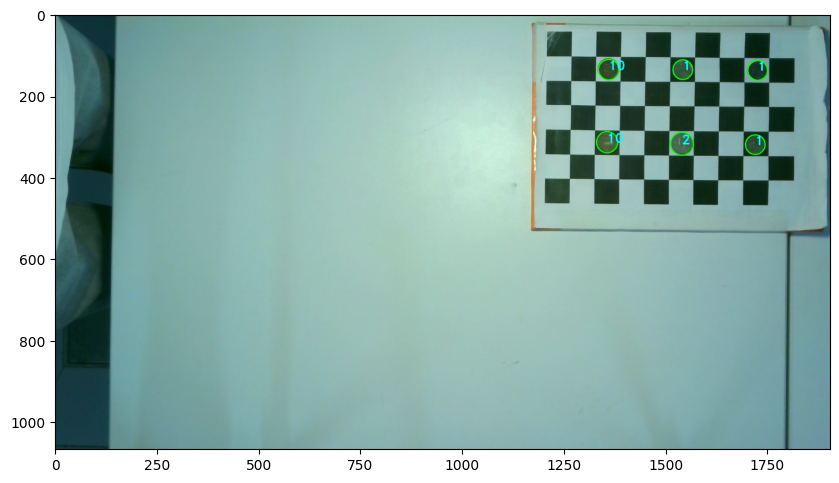

coins\01.jpg
Detected coins = [10, 10, 1, 1, 10, 1], sum = 33


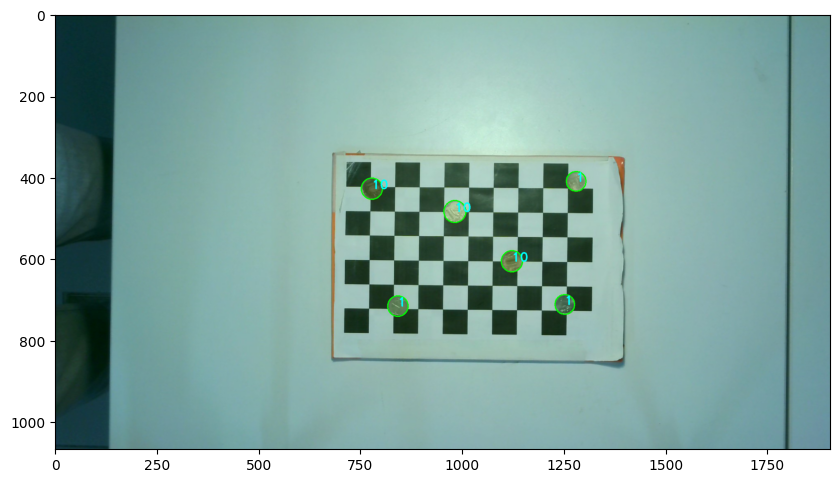

coins\02.jpg
Detected coins = [10, 10, 1, 1, 1, 2], sum = 25


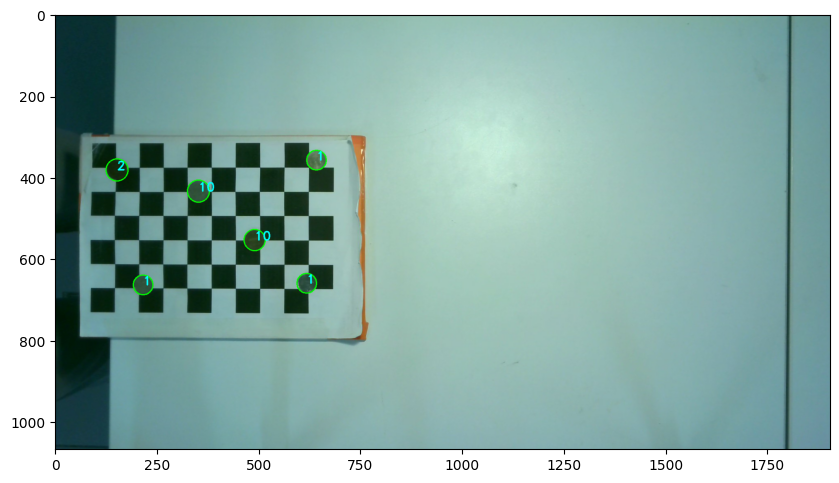

coins\03.jpg
Detected coins = [1, 1, 1, 1, 10, 5], sum = 19


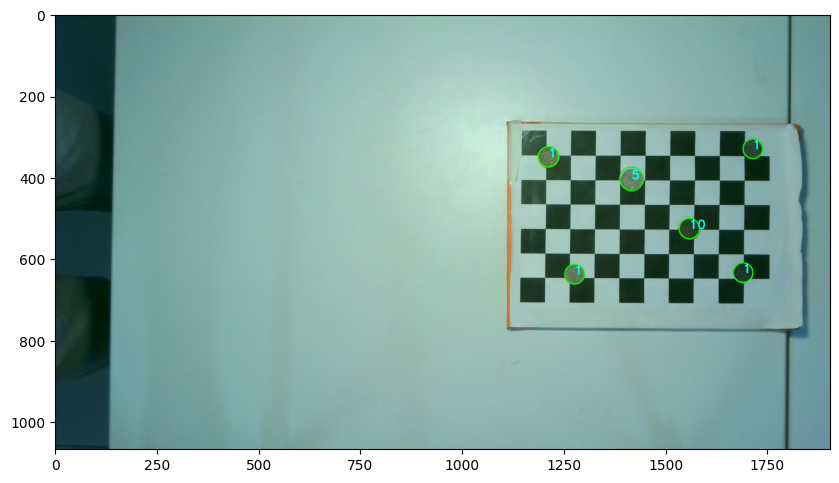

coins\04.jpg
Detected coins = [1, 2, 10, 1, 2, 1], sum = 17


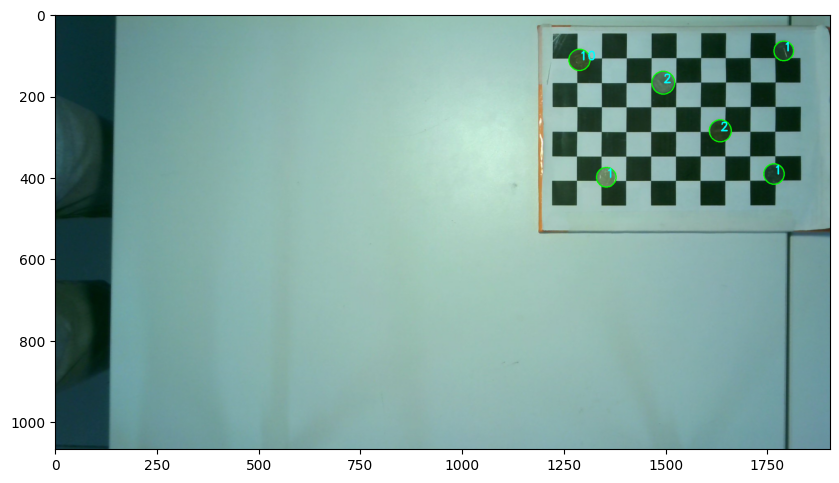

coins\05.jpg
Detected coins = [10, 1, 10, 1, 10], sum = 32


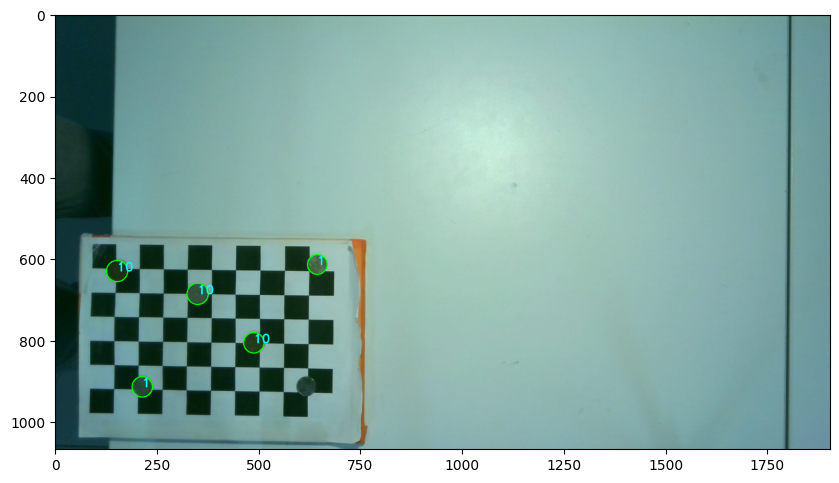

coins\06.jpg
Detected coins = [2, 1, 1, 10, 10, 1], sum = 25


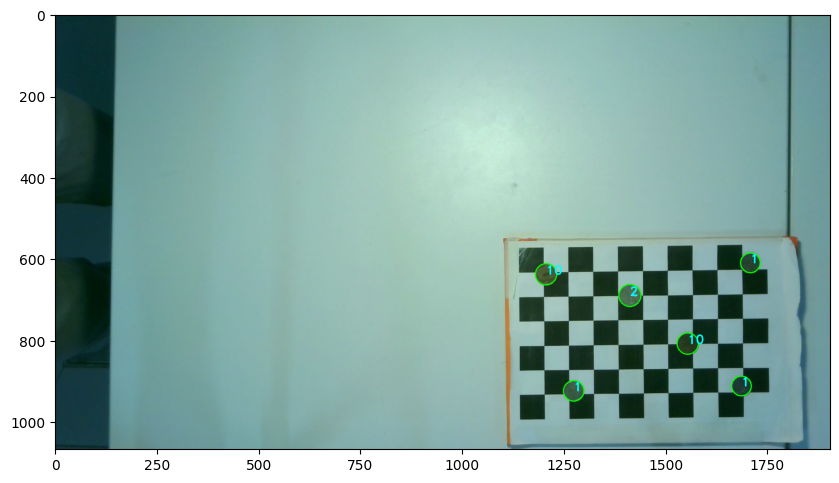

coins\07.jpg
Detected coins = [1, 10, 10, 1, 10], sum = 32


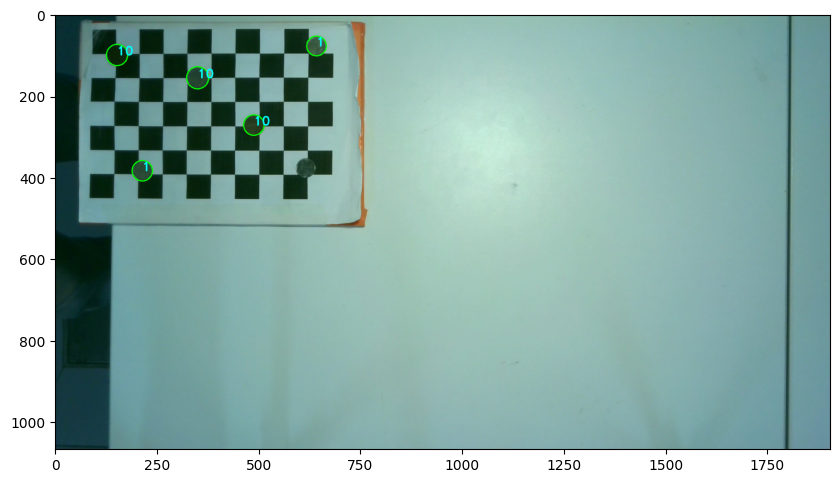

coins\08.jpg
Detected coins = [1, 2, 1, 10, 1, 1], sum = 16


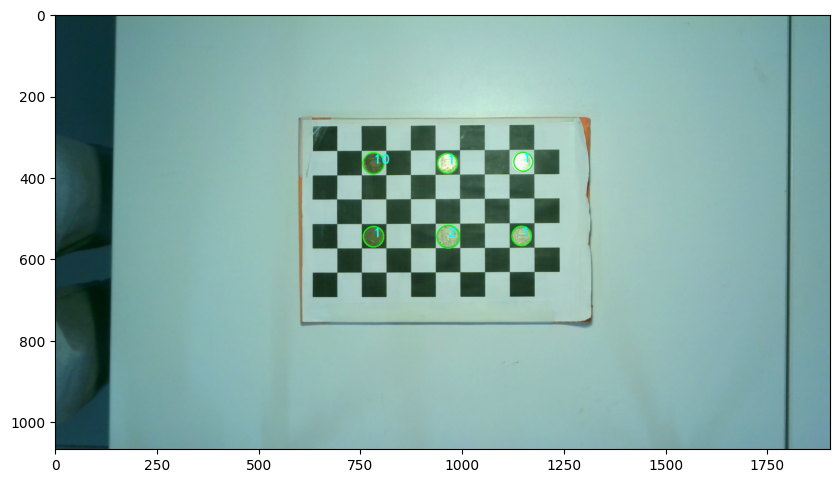

coins\09.jpg
Detected coins = [10, 1, 2, 1, 1], sum = 15


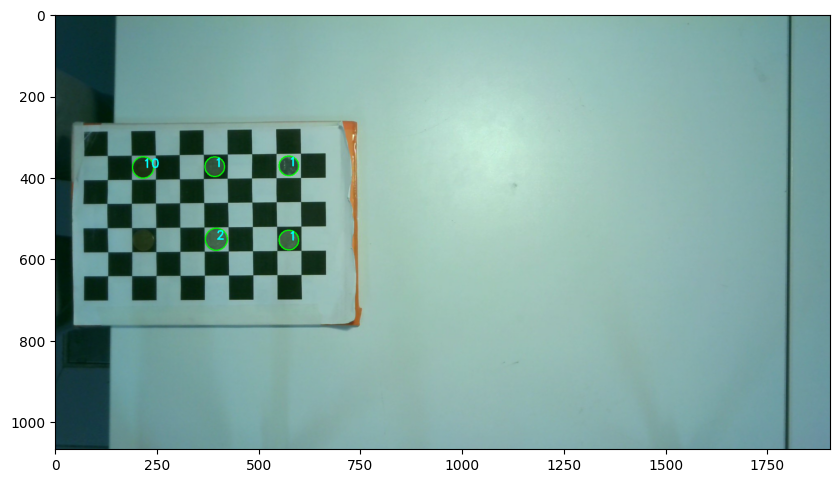

coins\10.jpg
Detected coins = [2, 1, 1, 10, 10, 1], sum = 25


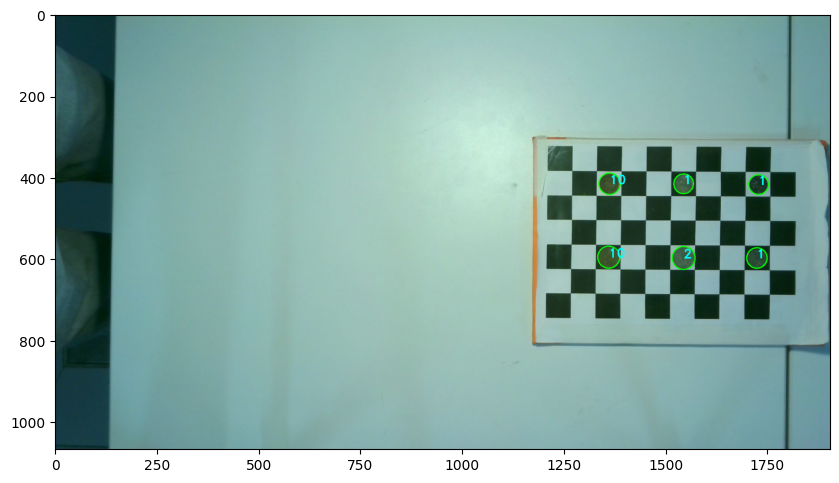

coins\11.jpg
Detected coins = [10, 2, 1, 1, 1], sum = 15


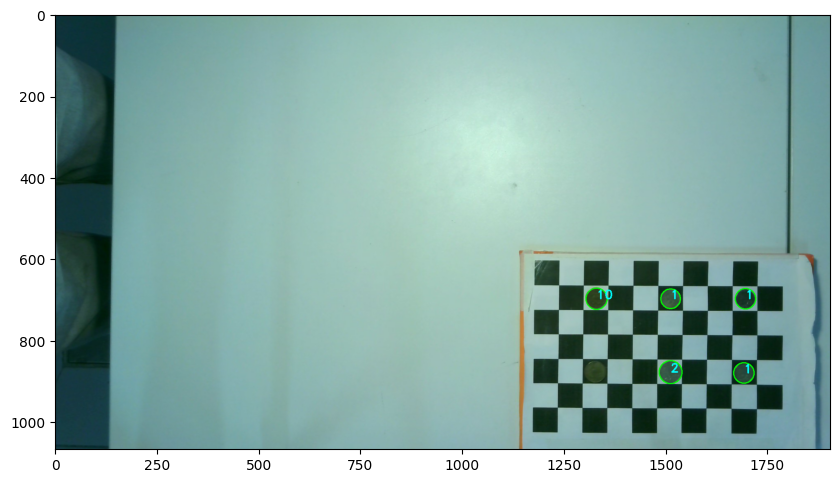

coins\12.jpg
Detected coins = [10, 2, 1, 1, 1], sum = 15


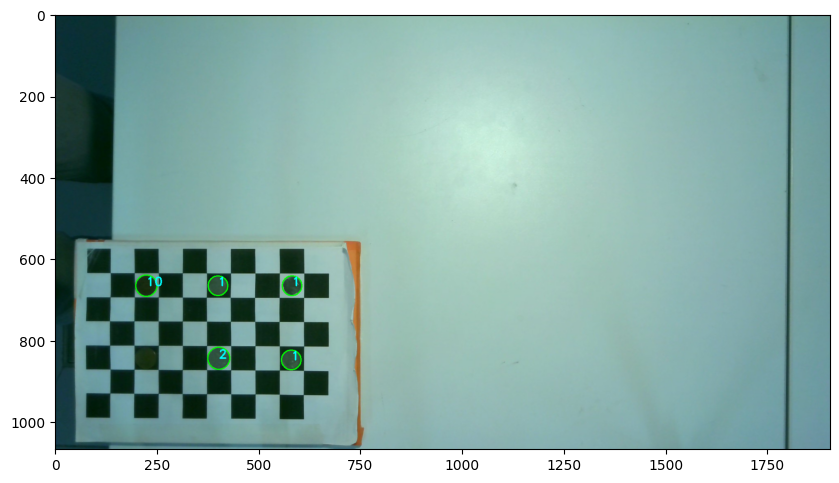

coins\13.jpg
Detected coins = [10, 1, 1, 2], sum = 14


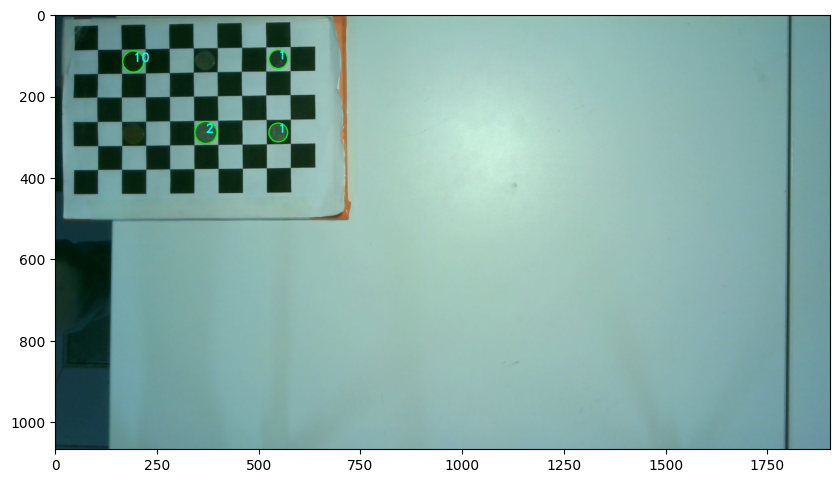

In [16]:
acc = []
target_sum = 25
coins_detected = 0
target_coins_detected = 6 * len(detection_fnames)

for fname in detection_fnames:
    print(fname)
    img = cv2.imread(fname)
    img_undistorted = undistort(img)
    detected_circles = detect_circles(img_undistorted)
    if detected_circles is not None:
        coins_detected += detected_circles.shape[1]
        values = find_coin_value(detected_circles[0, :, 2])
        acc.append(abs(sum(values) - target_sum) / target_sum)
        print(f'Detected coins = {list(values)}, sum = {sum(values)}')
        draw_circles(img_undistorted, detected_circles, values)
    plt.figure(figsize=[10, 10])
    plt.imshow(img_undistorted[:, :, ::-1])
    plt.show()

In [ ]:
print(f'Mean error per photo is {np.mean(acc)} ({acc})')
print(f'Mean accuracy is {round(100*(1 - np.mean(acc)))}%')
print(f'Total coins detected: {coins_detected} / {target_coins_detected}')
print(f'Coins detection accuracy: {round(100*coins_detected/target_coins_detected)}%')

Mean error per photo is 0.24571428571428572 ([0.0, 0.32, 0.0, 0.24, 0.32, 0.28, 0.0, 0.28, 0.36, 0.4, 0.0, 0.4, 0.4, 0.44])
Mean accuracy is 75%
Total coins detected: 77
Coins detection accuracy: 92%
